## Analyze motifs in endogenous yeast ORFs

In [39]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(plyranges))
suppressPackageStartupMessages(library(rasilabRtemplates))
suppressPackageStartupMessages(library(Biostrings))
suppressPackageStartupMessages(library(readxl))

In [ ]:
if (!file.exists('../data')){
    dir.create('../data')
}

if (!file.exists('../data/motifs')){
    dir.create('../data/motifs')
}

In [40]:
annotations <- read_gff3("../db/S288C_reference_genome_R64-3-1_20210421/sgd_gene_annotations.gff3") %>%
  as_tibble() %>%
  filter(type == "gene") %>%
  select(orf_classification, ID, gene, display) %>%
  janitor::clean_names() %>%
  print()

# A tibble: 6,607 × 4
   orf_classification id        gene  display                                   
   <chr>              <chr>     <chr> <chr>                                     
 1 Dubious            YAL069W   NA    Dubious open reading frame                
 2 Dubious            YAL068W-A NA    Dubious open reading frame                
 3 Verified           YAL068C   PAU8  Protein of unknown function               
 4 Uncharacterized    YAL067W-A NA    Putative protein of unknown function      
 5 Verified           YAL067C   SEO1  Putative permease                         
 6 Dubious            YAL066W   NA    Dubious open reading frame                
 7 Uncharacterized    YAL065C   NA    Putative protein of unknown function      
 8 Uncharacterized    YAL064W-B NA    Fungal-specific protein of unknown functi…
 9 Uncharacterized    YAL064C-A TDA8  Putative protein of unknown function      
10 Verified           YAL064W   NA    Protein of unknown function               
# … wi

### Read in scored motifs

- From ```calculate_stall_scores.ipynb```

In [41]:
# scoring presence of K/R and 'L/I/V/W/F/Y'
posbulky <- read_tsv("../data/stallscores/posbulky_motif_scores_sgd_orfs.tsv", show_col_types = F) %>%
  dplyr::rename(id = transcript_id) %>%
  print()

# A tibble: 128,783 × 6
   id    strength   loc motif                 nt63                         type 
   <chr>    <dbl> <dbl> <chr>                 <chr>                        <chr>
 1 Q0010     14.5    13 YIIFLYNILLIIILIFYSIVG TATATTATATTTTTATATAATATATTA… posb…
 2 Q0010     20      38 IFNNNYYWDPDIFLFIIYYFI ATTTTCAATAATAATTATTATTGGGAC… posb…
 3 Q0010     17.5    48 DIFLFIIYYFIKFIIIFNLYL GATATCTTCTTGTTTATCATTTATTAT… posb…
 4 Q0010     16      84 PGRGLYILLYNILYSYNIFID CCGGGGCGGGGACTTTATATTTTATTA… posb…
 5 Q0010     18      95 ILYSYNIFIDYVIKFILCVLY ATATTATATTCTTATAATATATTTATT… posb…
 6 Q0010     12.5   105 YVIKFILCVLYIYLIFWLLSP TATGTTATAAAATTTATTCTATGTGTG… posb…
 7 Q0010      7     112 CVLYIYLIFWLLSPTPSPYYV TGTGTGCTCTATATATATTTAATATTC… posb…
 8 Q0017     12       5 NA                    NA                           posb…
 9 Q0017     16      26 PLPLLRLRGPGFVRNRDLYIY CCCCTCCCCCTATTACGTCTCCGAGGT… posb…
10 Q0017     12.5    35 PGFVRNRDLYIYKYKSNLINN CCCGGTTTCGTAAGAAACCGGGACTTA… posb…
# … 

In [42]:
# scoring specifically for 'FK/KF' (with some additional weight to presence of R/W/Y), scoring 'PG/GP/PD/DP' dipeptides (with additional weight for any P/D/G presence)
dipeptides <- read_tsv("../data/stallscores/dipeptide_scores_sgd_orfs.tsv", show_col_types = F) %>%
  dplyr::rename(id = transcript_id) %>%
  print()

# A tibble: 16,854 × 6
   id    strength   loc motif                 nt63                         type 
   <chr>    <dbl> <dbl> <chr>                 <chr>                        <chr>
 1 Q0010       10    52 FIIYYFIKFIIIFNLYLYYII TTTATCATTTATTATTTTATTAAATTT… FK   
 2 Q0010        2    16 FLYNILLIIILIFYSIVGVPI TTTTTATATAATATATTATTAATTATT… FK   
 3 Q0017        1    47 KYKSNLINNLNNILYIL*    AAATATAAATCTAACTTAATTAATAAT… FK   
 4 Q0032        2     0 NA                    NA                           FK   
 5 Q0045        0   111 IAF*VLPMGLVCLVTSTLVES ATTGCTTTTTGAGTATTACCTATGGGG… FK   
 6 Q0050       12   311 GTGKFKFKPMRIVNIPKPKGG GGAACAGGTAAATTCAAATTTAAACCC… FK   
 7 Q0050       10   514 GPLFIYNDPNFKRIKYVRYAD GGCCCACTATTTATTTATAATGATCCT… FK   
 8 Q0050       10   699 LASKYRLKTISKTIKKFGYNL TTAGCTAGTAAATATAGATTAAAAACA… FK   
 9 Q0050        0   245 FEKLVIDNINEENINNNLLSI TTTGAGAAATTAGTAATAGATAATATA… FK   
10 Q0055       11   731 TLARKFKLNTVKKVILKFGKV ACATTAGCAAGAAAATTTAAATTAAAT… FK   
# … w

### Remove any motifs with stop codons or NAs (exist near the ends of the gene), tabulate amino acid types

In [43]:
motifs <- bind_rows(posbulky, dipeptides) %>%
    drop_na() %>%
    filter(!str_detect(motif, '\\*')) %>% # some motifs have stop codons
    mutate(positive = str_count(motif, 'K|R')) %>%
    mutate(bulky = str_count(motif, 'W|F|Y|L|I|V')) %>%
    mutate(p = str_count(motif, 'P'), g = str_count(motif, 'G'), d = str_count(motif, 'D')) %>%
    arrange(desc(strength))

head(motifs)

id,strength,loc,motif,nt63,type,positive,bulky,p,g,d
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>
YOR309C,24,55,KLRRKRRTRRKRRKRRKRRRR,AAGCTAAGAAGGAAAAGAAGGACAAGAAGGAAAAGAAGGAAAAGAAGGAAAAGAAGGAGAAGA,posbulky,19,1,0,0,0
YHR131C,22,319,LEVREYPDYRIVPRRRRRRRR,TTGGAAGTCAGGGAGTATCCAGATTATCGAATTGTTCCCAGAAGAAGGAGAAGGAGAAGGAGG,posbulky,10,6,2,0,1
YKL030W,22,17,CCCYCFYYCIIVLLLYYYYYY,TGCTGTTGTTATTGTTTTTATTATTGTATTATTGTATTATTATTATATTATTATTATTATTAT,posbulky,0,16,0,0,0
YDR504C,21,37,FSLFLFLFVFVFVFIFVYFFY,TTTTCATTGTTTTTGTTTTTGTTTGTTTTTGTTTTTGTTTTTATTTTTGTCTACTTTTTTTAT,posbulky,0,20,0,0,0
YER158W-A,21,36,LLLRIDLPLRNRIFRRLKLFF,CTTCTTCTACGCATAGACCTTCCCTTAAGAAATCGAATTTTTCGTCGTTTAAAATTGTTTTTT,posbulky,6,12,1,0,1
YGR004W,21,219,LTYHSKLIRRMRRYLWKFRVV,CTTACGTACCATTCTAAACTAATCCGAAGAATGAGAAGATACTTGTGGAAATTTCGCGTTGTT,posbulky,7,10,0,0,0


## Pick posbulky and FK motifs based on SDD1 
- Pick motifs that are at least as strong and have approx the same posbulky pattern as SDD1, since we pulled out this motif using our method

In [44]:
annotations %>%
  filter(gene == "SDD1") %>%
  left_join(motifs, by = 'id') %>%
  group_by(type, motif, positive, bulky) %>%
  summarize(max=max(strength)) %>%
  arrange(desc(max))

`summarise()` has grouped output by 'type', 'motif', 'positive'. You can
override using the `.groups` argument.


type,motif,positive,bulky,max
<chr>,<chr>,<int>,<int>,<dbl>
posbulky,DFFYEDYLIFDCRAKRRKKLK,7,8,19.0
posbulky,VVRSSFIESDFFYEDYLIFDC,1,11,15.5
posbulky,ITYKYLSNENCKEENKFGTFI,3,7,15.0
posbulky,AILKQVHLDNANIENKRILKE,4,7,14.0
posbulky,MANDGIQRNDNRKGFKTVQFS,4,4,12.5
⋮,⋮,⋮,⋮,⋮
posbulky,LDNLAATLHDQVLKLQATLFP,1,8,10.5
FK,YLIFDCRAKRRKKLKRKILFI,9,9,10.0
posbulky,NIENKRILKEITYKYLSNENC,4,7,10.0


In [45]:
fk_subset_sdd1 <- motifs %>%
    filter(type =='FK', strength>=10, positive >= 8, bulky >= 8) %>%
    group_by(motif) %>% 
    dplyr::slice(1) %>% # remove any duplicate motifs
    ungroup()

In [46]:
posbulky_subset_sdd1 <- motifs %>%
  filter(type == 'posbulky', strength >= 19, positive >= 6, bulky >= 7) %>%
  group_by(motif) %>%
  dplyr::slice(1) %>%
  ungroup()

- Because 'posbulky' and 'FK' type motifs are scored similarly, there are duplicate motifs present
- For motifs that are from the same general locations (overlapping but not identical), drop the 'FK' type motif and keep the 'posbulky' one

In [47]:
bind_rows(fk_subset_sdd1, posbulky_subset_sdd1) %>%
    left_join(annotations, by = 'id') %>%
    arrange(desc(strength)) %>%
    group_by(id) %>%
    summarize(n_motifs = dplyr::n()) %>%
    filter(n_motifs >1)

id,n_motifs
<chr>,<int>
YDL030W,2
YEL057C,2
YHR073W,2
YLL048C,2
YLR312C,2
YMR207C,2
YPL158C,2


In [48]:
contains_duplicates <- c('YDL030W', 'YEL057C', 'YHR073W', 'YLL048C', 'YLR312C', 'YMR207C', 'YPL158C')

subset_motifs_to_sdd1 <- bind_rows(fk_subset_sdd1, posbulky_subset_sdd1) %>%
    left_join(annotations, by = 'id') %>%
    arrange(desc(strength)) %>%
    mutate(type = ifelse( (id %in% contains_duplicates) & (type == 'FK'), NA, type)) %>%
    drop_na(type) %>%
    mutate(class = 'endo_stall') %>%
    arrange(id)

subset_motifs_to_sdd1

id,strength,loc,motif,nt63,type,positive,bulky,p,g,d,orf_classification,gene,display,class
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>
YAR047C,19.5,66,KRFLYRQIMIALKIKAKKFWF,AAGCGTTTCCTGTATAGGCAGATAATGATTGCATTGAAAATAAAAGCCAAAAAATTTTGGTTC,posbulky,7,10,0,0,0,Dubious,NA,Dubious open reading frame,endo_stall
YBL027W,19.5,94,TREARLPSQVVWIRRLRVLRR,ACTAGAGAAGCTCGTTTACCATCCCAAGTCGTCTGGATCAGAAGATTACGTGTCTTGAGAAGA,posbulky,7,8,1,0,0,Verified,RPL19B,Ribosomal 60S subunit protein L19B,endo_stall
YBR129C,12.0,232,LYTKVKKKKLFNRAKWQKFNV,CTTTACACAAAAGTGAAAAAGAAGAAACTGTTCAATAGGGCTAAATGGCAAAAGTTCAATGTG,FK,8,8,0,0,0,Verified,OPY1,Protein of unknown function,endo_stall
YCL054W,10.0,318,KVLGKKDFKMILRWRKIAREI,AAAGTCTTGGGTAAAAAGGATTTTAAAATGATCCTAAGATGGAGAAAGATTGCAAGGGAAATC,FK,8,8,0,1,1,Verified,SPB1,AdoMet-dependent methyltransferase,endo_stall
YDL030W,20.5,57,KLPRSSLIAENKIYKFKKVKR,AAACTGCCTAGATCATCGTTGATTGCAGAGAATAAAATATACAAGTTTAAAAAGGTTAAGAGG,posbulky,8,7,1,0,0,Verified,PRP9,Subunit of the SF3a splicing factor complex,endo_stall
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
YOR309C,20,15,IPQRLLLILNPILMMKRKKRK,ATACCGCAAAGGCTGCTTCTGATTCTGAATCCGATTCTGATGATGAAGAGGAAGAAAAGAAAG,posbulky,7,8,2,0,0,Dubious,NA,Dubious open reading frame,endo_stall
YOR320C,12,368,KKIIYKQFIFFRKVRKLFKPE,AAGAAGATTATTTATAAACAGTTTATTTTCTTCAGAAAAGTCCGAAAACTTTTCAAACCAGAA,FK,8,10,1,0,0,Verified,GNT1,N-acetylglucosaminyltransferase,endo_stall
YPL147W,15,95,IILKCYKFYKFPWKRRNRRPL,ATTATTCTAAAATGTTATAAATTTTACAAGTTTCCATGGAAGAGAAGGAATAGGAGACCTTTA,FK,8,9,2,0,0,Verified,PXA1,"Subunit of heterodimeric peroxisomal ABC transport complex, with Pxa2p",endo_stall


## Pick PG/PD motifs

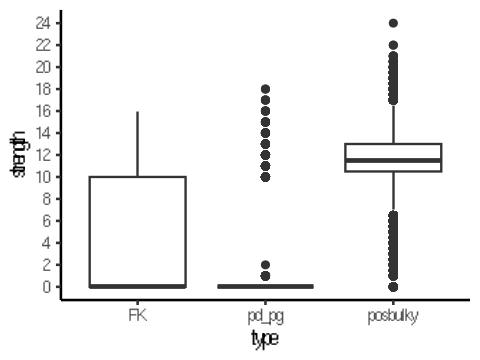

In [49]:
motifs %>%
    ggplot() +
    aes(x=type, y=strength, group=type) +
    geom_boxplot() +
    scale_y_continuous(breaks=seq(0,25,2))

In [50]:
pd_pg_subset <- motifs %>%
    filter(type == 'pd_pg') %>%
    filter( (p >= 3) & (g + d > 7) ) %>%
    left_join(annotations, by = 'id') %>%
    mutate(class = 'endo_stall') %>%
    arrange(id)

In [51]:
subset_motifs <- bind_rows(subset_motifs_to_sdd1, pd_pg_subset)
subset_motifs

id,strength,loc,motif,nt63,type,positive,bulky,p,g,d,orf_classification,gene,display,class
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>
YAR047C,19.5,66,KRFLYRQIMIALKIKAKKFWF,AAGCGTTTCCTGTATAGGCAGATAATGATTGCATTGAAAATAAAAGCCAAAAAATTTTGGTTC,posbulky,7,10,0,0,0,Dubious,NA,Dubious open reading frame,endo_stall
YBL027W,19.5,94,TREARLPSQVVWIRRLRVLRR,ACTAGAGAAGCTCGTTTACCATCCCAAGTCGTCTGGATCAGAAGATTACGTGTCTTGAGAAGA,posbulky,7,8,1,0,0,Verified,RPL19B,Ribosomal 60S subunit protein L19B,endo_stall
YBR129C,12.0,232,LYTKVKKKKLFNRAKWQKFNV,CTTTACACAAAAGTGAAAAAGAAGAAACTGTTCAATAGGGCTAAATGGCAAAAGTTCAATGTG,FK,8,8,0,0,0,Verified,OPY1,Protein of unknown function,endo_stall
YCL054W,10.0,318,KVLGKKDFKMILRWRKIAREI,AAAGTCTTGGGTAAAAAGGATTTTAAAATGATCCTAAGATGGAGAAAGATTGCAAGGGAAATC,FK,8,8,0,1,1,Verified,SPB1,AdoMet-dependent methyltransferase,endo_stall
YDL030W,20.5,57,KLPRSSLIAENKIYKFKKVKR,AAACTGCCTAGATCATCGTTGATTGCAGAGAATAAAATATACAAGTTTAAAAAGGTTAAGAGG,posbulky,8,7,1,0,0,Verified,PRP9,Subunit of the SF3a splicing factor complex,endo_stall
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
YMR214W,18,103,KNGGGGGGPGGPGAGGFHDPF,AAGAATGGCGGTGGCGGTGGCGGTCCAGGAGGCCCTGGCGCAGGTGGATTCCACGATCCGTTT,pd_pg,1,2,3,11,1,Verified,SCJ1,One of several homologs of bacterial chaperone DnaJ,endo_stall
YNL007C,18,87,PSFGPGGPGGAGGAGGFPGGA,CCAAGCTTTGGTCCTGGTGGTCCTGGCGGTGCTGGAGGTGCTGGAGGCTTCCCTGGCGGTGCG,pd_pg,0,2,4,11,0,Verified,SIS1,Type II HSP40 co-chaperone that interacts with the HSP70 protein Ssa1p,endo_stall
YNL208W,17,134,GGFGGPGGPGGQGFGRQGPQG,GGTGGATTTGGCGGTCCAGGCGGCCCTGGCGGTCAAGGTTTCGGAAGACAAGGCCCACAAGGA,pd_pg,1,2,3,12,0,Verified,NA,Protein of unknown function,endo_stall


### Pull out the control genes
- For genes where a stalling motif was identified, a control motif was pulled from the argmin location

In [52]:
posbulky_genes <- subset_motifs %>%
    filter(type == 'posbulky') %>%
    dplyr::pull(id)

fk_genes <- subset_motifs %>%
    filter(type == 'FK') %>%
    dplyr::pull(id)

pdg_genes <- subset_motifs %>%
    filter(type == 'pd_pg') %>%
    dplyr::pull(id)

In [53]:
posbulky_min_cntrl <- motifs %>%
    filter(id %in% posbulky_genes) %>%
    group_by(id) %>%
    summarize(strength = min(strength), .groups='drop') %>%
    left_join(motifs, by=c('id', 'strength')) %>%
    filter(type == 'posbulky') %>%
    mutate(type='posbulky_no_stall_cntrl')

fk_min_cntrl <- motifs %>%
    filter(id %in% fk_genes) %>%
    group_by(id) %>%
    summarize(strength = min(strength), .groups='drop') %>%
    left_join(motifs, by=c('id', 'strength')) %>%
    filter(type == 'FK') %>%
    mutate(type='FK_no_stall_cntrl')

pdg_min_cntrl <- motifs %>%
    filter(id %in% pdg_genes) %>%
    group_by(id) %>%
    summarize(strength = min(strength), .groups='drop') %>%
    left_join(motifs, by=c('id', 'strength')) %>%
    filter(type == 'pd_pg') %>%
    mutate(type='pdg_no_stall_cntrl')

min_control_genes <- bind_rows(posbulky_min_cntrl, fk_min_cntrl, pdg_min_cntrl) %>%
    left_join(annotations, by='id') %>%
    mutate(class='endo_nostall')

In [54]:
subset_motifs_cntrls <- bind_rows(subset_motifs, min_control_genes)
tail(subset_motifs_cntrls)

id,strength,loc,motif,nt63,type,positive,bulky,p,g,d,orf_classification,gene,display,class
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>
YER103W,0,122,FTPEEISSMILTKMKETAENF,TTTACTCCAGAAGAAATTTCCTCAATGATCTTGACAAAGATGAAGGAGACTGCTGAGAACTTT,pdg_no_stall_cntrl,2,5,1,0,0,Verified,SSA4,Heat shock protein that is highly induced upon stress,endo_nostall
YFR006W,0,267,ALPIELNELQIQAEFEYHATR,GCGTTGCCCATCGAACTGAACGAGTTACAAATACAAGCTGAATTTGAATACCATGCAACCCGT,pdg_no_stall_cntrl,1,7,1,0,0,Uncharacterized,NA,Putative X-Pro aminopeptidase,endo_nostall
YHR034C,0,136,CDDIQLREILVEWCLESCEIR,TGCGATGATATCCAACTGCGAGAGATACTGGTCGAATGGTGCTTGGAGTCATGTGAGATCCGA,pdg_no_stall_cntrl,2,8,0,0,2,Verified,PIH1,Component of the conserved R2TP complex (Rvb1-Rvb2-Tah1-Pih1),endo_nostall
YLR338W,0,270,IYGRLLQQTVVRFLVVCFVSY,ATATATGGTAGGCTTCTTCAACAAACGGTTGTGCGCTTTTTAGTCGTATGCTTTGTCTCATAT,pdg_no_stall_cntrl,2,13,0,1,0,Dubious,OPI9,Dubious open reading frame,endo_nostall
YMR214W,0,41,DKDATEKEIKSAYRQLSKKYH,GACAAAGATGCCACTGAGAAGGAAATCAAATCAGCGTACAGACAATTGTCTAAGAAGTACCAT,pdg_no_stall_cntrl,6,4,0,0,2,Verified,SCJ1,One of several homologs of bacterial chaperone DnaJ,endo_nostall
YOR273C,0,91,DNPHNWSSLKKWYTTMTSAFL,GACAATCCGCATAATTGGTCCTCTTTGAAGAAATGGTATACTACTATGACTTCAGCTTTTCTT,pdg_no_stall_cntrl,2,6,1,0,1,Verified,TPO4,Polyamine transporter of the major facilitator superfamily,endo_nostall


## Generate alanine controls for endogenous motifs
- Replace all bulky residues with alanine 
- Use the most common Ala codon (GCA)

### Replace all bulky residues with GCA alanine

In [55]:
subset_motifs_cntrls_ala <- subset_motifs_cntrls %>%
  filter(class == 'endo_stall') %>%
  select(motif, nt63, id, gene, type) %>%
  mutate(nt63_1 = gsub("(.{3})", "\\1 ", nt63)) %>%
  separate(nt63_1, c(as.character(seq(1,21,1))), " ") %>%
  mutate(across(6:26, ~str_replace(., "TGG|TTT|TTC|TAT|TAC|TTA|TTG|CTT|CTC|CTA|CTG|GTT|GTC|GTA|GTG|ATC|ATA|ATT", 'GCA'))) %>%
  unite(ala_nt63, as.character(seq(1,21,1)), sep='') %>%
  mutate(orf_classification = 'ala_control') %>%
  mutate(class ='endo_ala_cntrl') %>%
  mutate(ala_motif = as.character(translate(DNAStringSet(ala_nt63), no.init.codon = T))) %>%
  select(ala_motif, ala_nt63, type, id, gene, orf_classification, class) %>%
  dplyr::rename(motif=ala_motif, nt63=ala_nt63) %>%
  mutate(positive = str_count(motif, 'K|R')) %>%
  mutate(bulky = str_count(motif, 'W|F|Y|L|I|V')) %>%
  mutate(p = str_count(motif, 'P'), g = str_count(motif, 'G'), d = str_count(motif, 'D')) %>%
  bind_rows(select(subset_motifs_cntrls, -display))

Warning message:
“Expected 21 pieces. Additional pieces discarded in 66 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


### Endogenous motifs summary

- Each gene should have up to 2-3 motifs total
  - the stall motif of interest
  - stall motif with all bulky residues replaced with GCA
  - a nostall motif control
- Some genes may not have had a nostall control if the motif was too close to the ends, these genes would be have 2 motifs

In [56]:
subset_motifs_cntrls_ala %>%
    group_by(id) %>%
    summarize(n_motifs=dplyr::n()) %>%
    arrange(n_motifs) %>%
    head()
    
multiple_motifs_per_id <- subset_motifs_cntrls_ala %>%
    group_by(id) %>%
    summarize(n_motifs=dplyr::n()) %>%
    filter(n_motifs>3) %>%
    dplyr::pull(id)

id,n_motifs
<chr>,<int>
YAR047C,2
YBL027W,2
YBR101C,2
YBR129C,2
YDL030W,2
YDL056W,2


- 7 motifs are overlapping (all PD/PG type), keep them for now

In [57]:
subset_motifs_cntrls_ala %>%
    filter(id %in% multiple_motifs_per_id) %>%
    filter(class == 'endo_stall') %>%
    arrange(id)


motif,nt63,type,id,gene,orf_classification,class,positive,bulky,p,g,d,strength,loc
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
GGSRGGYDGPRGDYGPPRDAY,GGTGGTTCAAGAGGTGGTTATGATGGTCCAAGAGGCGATTATGGTCCTCCAAGAGATGCATAC,pd_pg,YDR432W,NPL3,Verified,endo_stall,3,3,3,7,3,13,391
GYSRGGYGGPRNDYGPPRGSY,GGTTATTCCAGAGGTGGCTATGGTGGTCCAAGAAATGATTACGGTCCTCCAAGAGGTAGCTAC,pd_pg,YDR432W,NPL3,Verified,endo_stall,3,4,3,7,1,12,370
NDYGPPRGSYGGSRGGYDGPR,AATGATTACGGTCCTCCAAGAGGTAGCTACGGTGGTTCAAGAGGTGGTTATGATGGTCCAAGA,pd_pg,YDR432W,NPL3,Verified,endo_stall,3,3,3,7,2,12,381
LLPSPDLPGSDDPIAGDPDVD,CTTCTACCTTCCCCGGATCTCCCGGGTAGCGATGACCCTATTGCAGGTGATCCTGATGTAGAC,pd_pg,YDR456W,NHX1,Verified,endo_stall,0,5,5,2,6,16,40
RAVDPDDDDELLPSPDLPGSD,AGAGCAGTTGATCCTGACGATGATGATGAACTTCTACCTTCCCCGGATCTCCCGGGTAGCGAT,pd_pg,YDR456W,NHX1,Verified,endo_stall,1,4,4,1,7,15,30
GGFGGPGGPGGQGFGRQGPQG,GGTGGATTTGGCGGTCCAGGCGGCCCTGGCGGTCAAGGTTTCGGAAGACAAGGCCCACAAGGA,pd_pg,YNL208W,NA,Verified,endo_stall,1,2,3,12,0,17,134
GRQGPQGFGGPGPQEFGGPGG,GGAAGACAAGGCCCACAAGGATTTGGAGGTCCTGGTCCACAAGAGTTTGGTGGTCCAGGTGGC,pd_pg,YNL208W,NA,Verified,endo_stall,1,2,4,10,0,17,148


## Include some highly positive endogenous controls
- I want to rule out the idea/possibility that it's just the repetitive structure of the dicodon insert that causes stalling. 
- I suspect that any endogenous motifs with lots of K/R will also stall/get destabilized in a reporter context (even though they don't stall endogenously according to Barros2020)
- So these irregular K/R-heavy motifs can be additional K/R positive controls while also showing that the dicodon repeat structure is not what causes stalling

In [58]:
endogenous_kr_motfs <- motifs %>%
    filter(positive >= 10 & bulky <= 1) %>%
    filter(strength >= 18) %>% # arbitrary, just keep ~10
    mutate(class = 'endo_kr_cntrl')

endogenous_kr_motfs

id,strength,loc,motif,nt63,type,positive,bulky,p,g,d,class
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>
YOR309C,24.0,55,KLRRKRRTRRKRRKRRKRRRR,AAGCTAAGAAGGAAAAGAAGGACAAGAAGGAAAAGAAGGAAAAGAAGGAAAAGAAGGAGAAGA,posbulky,19,1,0,0,0,endo_kr_cntrl
YOR053W,21.0,49,HRRHHRRHHHHRRRRRRRRRR,CATCGTCGTCATCATCGTCGTCATCATCATCATCGTCGTCGTCGTCGTCGTCGTCGTCGTCGT,posbulky,14,0,0,0,0,endo_kr_cntrl
YBL091C,19.0,40,AKADESDPVESKKKKNKKKKK,GCAAAAGCTGACGAGTCAGACCCAGTAGAAAGCAAAAAGAAGAAGAACAAGAAAAAGAAGAAG,posbulky,10,1,1,0,2,endo_kr_cntrl
YLR204W,18.5,91,MRKRKKKMKKHKLRKRRKREK,ATGAGAAAGAGGAAAAAAAAGATGAAGAAACACAAACTGCGGAAAAGAAGAAAGAGGGAGAAG,posbulky,16,1,0,0,0,endo_kr_cntrl
YDR033W,18.0,301,RPAATPNLSKDKKKKSKKSKK,AGACCTGCTGCTACACCAAACTTGAGTAAGGACAAGAAAAAGAAGTCTAAGAAGAGCAAGAAA,posbulky,10,1,2,0,1,endo_kr_cntrl
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
YLR175W,18,451,KDKKEKKEKKEKKDKKEKKEK,AAGGACAAGAAGGAAAAGAAGGAAAAGAAAGAAAAGAAGGACAAGAAGGAAAAGAAAGAGAAA,posbulky,14,0,0,0,2,endo_kr_cntrl
YLR197W,18,485,KEKKEKKEKKDKKEKKDKKEK,AAGGAAAAGAAAGAAAAGAAGGAAAAGAAGGACAAAAAGGAAAAGAAAGATAAAAAGGAAAAG,posbulky,14,0,0,0,2,endo_kr_cntrl
YMR219W,18,1609,ETNREKDKTKAKKKSRKRNYN,GAAACAAACCGCGAAAAGGACAAAACTAAAGCAAAAAAGAAAAGCCGTAAAAGAAACTACAAC,posbulky,10,1,0,0,1,endo_kr_cntrl


## Merge all into one final dataframe

In [59]:
stall_motifs_controls <- bind_rows(subset_motifs_cntrls_ala, endogenous_kr_motfs) %>%
    print()

# A tibble: 171 × 14
   motif   nt63  type  id    gene  orf_c…¹ class posit…² bulky     p     g     d
   <chr>   <chr> <chr> <chr> <chr> <chr>   <chr>   <int> <int> <int> <int> <int>
 1 KRAAAR… AAGC… posb… YAR0… NA    ala_co… endo…       7     0     0     0     0
 2 TREARA… ACTA… posb… YBL0… RPL1… ala_co… endo…       7     0     1     0     0
 3 AATKAK… GCAG… FK    YBR1… OPY1  ala_co… endo…       8     0     0     0     0
 4 KAAGKK… AAAG… FK    YCL0… SPB1  ala_co… endo…       8     0     0     1     1
 5 KAPRSS… AAAG… posb… YDL0… PRP9  ala_co… endo…       8     0     1     0     0
 6 AAKACH… GCAG… posb… YDL0… GPR1  ala_co… endo…       6     0     0     3     0
 7 EAASRA… GAAG… posb… YDL0… MBP1  ala_co… endo…       7     0     0     0     0
 8 SRAKAK… AGCC… FK    YDR0… RAD28 ala_co… endo…       8     0     0     0     1
 9 DAAAED… GATG… posb… YEL0… SDD1  ala_co… endo…       7     0     0     0     3
10 KKQAEE… AAAA… posb… YER0… TSC11 ala_co… endo…       6     0     0     0     0
# … wit

In [60]:
stall_motifs_controls %>%
    mutate(len = nchar(motif)) %>%
    group_by(class, len) %>%
    summarize(dplyr::n())

`summarise()` has grouped output by 'class'. You can override using the
`.groups` argument.


class,len,dplyr::n()
<chr>,<int>,<int>
endo_ala_cntrl,21,66
endo_kr_cntrl,21,12
endo_nostall,21,27
endo_stall,21,66


In [61]:
stall_motifs_controls %>%
    write_tsv("../data/motifs/stall_motifs_controls.tsv")